In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torchvision import datasets,transforms,models

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.metrics import confusion_matrix

In [10]:
transform=transforms.ToTensor()

In [36]:
train_data=datasets.FashionMNIST(root="F_Mnist",train=True,download=True,transform=transform)
test_data=datasets.FashionMNIST(root="F_Mnist",train=False,download=True,transform=transform)

train_loader=DataLoader(train_data,batch_size=10,shuffle=True)
test_loader=DataLoader(test_data,batch_size=10,shuffle=True)

In [37]:

classes_names=train_data.classes
print(classes_names)

['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat', 'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']


In [54]:
len(test_data)


10000

In [39]:
for i,(images,labels) in enumerate(train_loader):
    break
print(images.shape)

torch.Size([10, 1, 28, 28])


In [45]:
class F_CNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.Sequential=nn.Sequential(
            nn.Conv2d(1,6,3,1), # input,output,Kernel_size,stride # 26,26
            nn.ReLU(),
            nn.MaxPool2d(2,2), # 13,13
            nn.Conv2d(6,16,3,1), #11,11
            nn.ReLU(),
            nn.MaxPool2d(2,2)  #5,5
        )
     
        self.fc1=nn.Linear(16*5*5,84)
        self.fc2=nn.Linear(84,10)
        
    def forward(self,x):
        x=self.Sequential(x)
        x=x.view(-1,16*5*5)
        x=F.relu(self.fc1(x))
        x=self.fc2(x)
        
        return F.log_softmax(x,dim=1)
        



In [46]:
model=F_CNN()
model

F_CNN(
  (Sequential): Sequential(
    (0): Conv2d(1, 6, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(6, 16, kernel_size=(3, 3), stride=(1, 1))
    (4): ReLU()
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (fc1): Linear(in_features=400, out_features=84, bias=True)
  (fc2): Linear(in_features=84, out_features=10, bias=True)
)

In [47]:
for param in model.parameters():
    print(param.numel())

54
6
864
16
33600
84
840
10


In [48]:
criterion=nn.CrossEntropyLoss()
optimizer=torch.optim.SGD(model.parameters(),lr=0.001,momentum=0.7)

In [49]:
train_losses=[]
test_losses=[]
train_acc=[]
test_acc=[]

epochs=5

for epoch in range(epochs):
    correct_train=0
    correct_test=0
    
    for b,(x_train,y_train) in enumerate(train_loader):
        b+=1
        y_pred=model(x_train)
        loss=criterion(y_pred,y_train)
        # ACC CALCULATE
        pred_max=torch.max(y_pred.data,1)[1]
        correct_train+=(pred_max==y_train).sum()
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        if(b%6000==0):
            print("Epoch {} Batch {} Loss {}".format(epoch,b,loss.item()))
    train_losses.append(loss.item())
    train_acc.append(correct_train)
    
    with torch.no_grad():
        for b,(x_test,y_test) in enumerate(test_loader):
            y_pred=model(x_test)
            pred_max=torch.max(y_pred.data,1)[1]
            correct_test+=(pred_max==y_test).sum()
        loss=criterion(y_pred,y_test)
        test_losses.append(loss.item())
        test_acc.append(correct_test)
        
        

Epoch 0 Batch 6000 Loss 0.7987012267112732
Epoch 1 Batch 6000 Loss 0.6438307762145996
Epoch 2 Batch 6000 Loss 1.0439417362213135
Epoch 3 Batch 6000 Loss 0.021302254870533943
Epoch 4 Batch 6000 Loss 0.7541567087173462


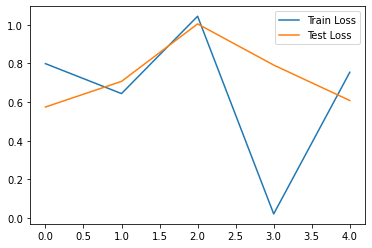

In [51]:
plt.plot(train_losses,label="Train Loss")
plt.plot(test_losses,label="Test Loss")
plt.legend()

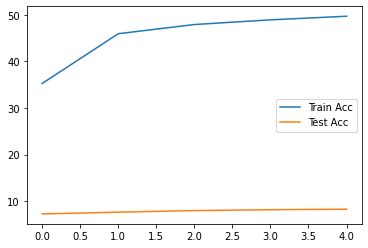

In [65]:
plt.plot([10*t/10000 for t in train_acc],label="Train Acc")
plt.plot([10*t/10000 for t in test_acc],label="Test Acc")
plt.legend()

In [67]:
a=[10*t/10000 for t in train_acc]
b=[100*t/10000 for t in test_acc]
print(a)
print(b)

[tensor(35.2760), tensor(45.9640), tensor(47.9360), tensor(48.9430), tensor(49.7180)]
[tensor(72.4500), tensor(76.2100), tensor(79.6100), tensor(81.4700), tensor(82.5500)]


In [55]:
test_loader_all=DataLoader(test_data,batch_size=10000,shuffle=False)
with torch.no_grad():
    correct=0
    for i,(test,label) in enumerate(test_loader_all):
        out=model(test)
        pred=torch.max(out.data,1)[1]
        correct+=(pred==label).sum()
correct.item()/len(test_data)

0.8255

In [57]:
100*test_acc[-1].item()/10000

82.55

In [74]:
from sklearn.metrics import classification_report
cm=confusion_matrix(pred.view(-1),label.view(-1))
cr=classification_report(pred.view(-1),label.view(-1))


In [75]:
cm

array([[804,   1,  17,  23,   2,   0, 212,   0,   3,   0],
       [  1, 952,   1,   8,   0,   0,   1,   0,   1,   0],
       [ 36,   1, 801,  25, 158,   0, 205,   0,  22,   0],
       [ 88,  38,  20, 905,  51,   2,  72,   0,   9,   0],
       [  6,   4, 121,  21, 711,   0, 151,   0,   2,   0],
       [  2,   1,   1,   0,   0, 931,   1,  27,   2,   8],
       [ 42,   1,  27,  11,  68,   0, 324,   0,   4,   0],
       [  1,   0,   0,   0,   0,  46,   0, 925,   4,  40],
       [ 20,   2,  12,   7,  10,   2,  34,   1, 951,   1],
       [  0,   0,   0,   0,   0,  19,   0,  47,   2, 951]], dtype=int64)

In [78]:
print(cr)

              precision    recall  f1-score   support

           0       0.80      0.76      0.78      1062
           1       0.95      0.99      0.97       964
           2       0.80      0.64      0.71      1248
           3       0.91      0.76      0.83      1185
           4       0.71      0.70      0.71      1016
           5       0.93      0.96      0.94       973
           6       0.32      0.68      0.44       477
           7       0.93      0.91      0.92      1016
           8       0.95      0.91      0.93      1040
           9       0.95      0.93      0.94      1019

    accuracy                           0.83     10000
   macro avg       0.83      0.82      0.82     10000
weighted avg       0.85      0.83      0.83     10000



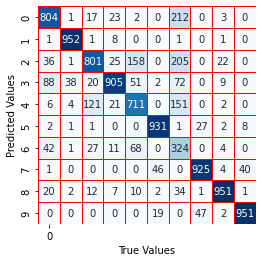

In [85]:
import seaborn as sns

sns.heatmap(cm,square=True, annot=True,cbar=False,cmap=plt.cm.Blues,fmt="d",linewidths=1,linecolor="red")

plt.xlabel("True Values")
plt.ylabel("Predicted Values")
plt.show()


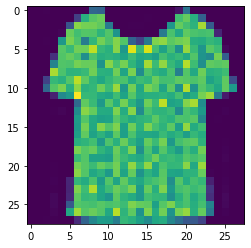

In [86]:
plt.imshow(test_data[1000][0].reshape(28,28))

In [89]:
model.eval()
with torch.no_grad():
    pred=model(test_data[1000][0].view(1,1,28,28))
pred=np.argmax(pred)
classes_names[pred.item()]

'T-shirt/top'

In [90]:
classes_names[test_data[1000][1]]

'T-shirt/top'